In [1]:
using Flux, Metalhead, Statistics
using Flux: onehotbatch, onecold, logitcrossentropy, throttle, flatten
using Metalhead: trainimgs
using Parameters: @with_kw
using Images: channelview
using Statistics: mean
using Base.Iterators: partition
using CUDAapi
if has_cuda()
    @info "CUDA is on"
    import CuArrays
    CuArrays.allowscalar(false)
end

┌ Info: CUDA is on
└ @ Main In[1]:10


In [24]:
using ImageTransformations
using Images, TestImages

┌ Info: Precompiling TestImages [5e47fb64-e119-507b-a336-dd2b206d9990]
└ @ Base loading.jl:1260


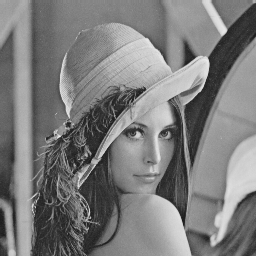

In [25]:
img = testimage("lena_gray")

In [27]:
@show summary(img);

summary(img) = "256×256 Array{Gray{N0f8},2} with eltype Gray{Normed{UInt8,8}}"


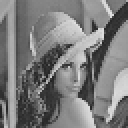

In [30]:
imresize(img,(64,64))

,,

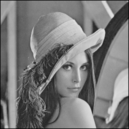
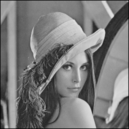
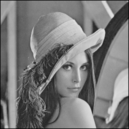

In [31]:
x = [testimage("lena_gray"),testimage("lena_gray"),testimage("lena_gray")]

In [39]:
function resiImg(X)
    return [imresize(i,(64,64)) for i in X]
    
end

resiImg (generic function with 1 method)

,,

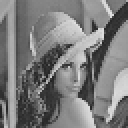
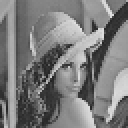
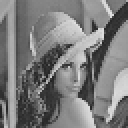

In [41]:
ar = resiImg(x)

In [49]:
X = trainimgs(CIFAR10)
imgs = [getarray(X[i].img) for i in 1:40000];

In [2]:
@with_kw mutable struct Args
    batchsize::Int = 8
    throttle::Int = 10
    lr::Float64 = 3e-4
    epochs::Int = 50
    splitr_::Float64 = 0.1
end

Args

In [3]:
# Function to convert the RGB image to Float64 Arrays
function getarray(X)
    Float32.(permutedims(channelview(X), (2, 3, 1)))
end

getarray (generic function with 1 method)

In [64]:
function get_processed_data(args)
    # Fetching the train and validation data and getting them into proper shape	
    X = trainimgs(CIFAR10)
    imgs = [getarray(X[i].img) for i in 1:40000]
#     imgs = resiImg(imgs)
    #onehot encode labels of batch
    imgs[1:5]
    labels = onehotbatch([X[i].ground_truth.class for i in 1:40000],1:10)
	
    train_pop = Int((1-args.splitr_)* 40000)
    train = gpu.([(cat(imgs[i]..., dims = 4), labels[:,i]) for i in partition(1:train_pop, args.batchsize)])
    valset = collect(train_pop+1:40000)
    valX = cat(imgs[valset]..., dims = 4) |> gpu
    valY = labels[:, valset] |> gpu
	
    val = (valX,valY)	
    return train, val
end

get_processed_data (generic function with 1 method)

In [65]:
function get_test_data()
    # Fetch the test data from Metalhead and get it into proper shape.
    test = valimgs(CIFAR10)

    # CIFAR-10 does not specify a validation set so valimgs fetch the testdata instead of testimgs
    testimgs = [getarray(test[i].img) for i in 1:1000]
    testY = onehotbatch([test[i].ground_truth.class for i in 1:1000], 1:10) |> gpu
    testX = cat(testimgs..., dims = 4) |> gpu

    test = (testX,testY)
    return test
end

get_test_data (generic function with 1 method)

In [77]:
# VGG16 and VGG19 models
function vgg16()
    return Chain(
            Conv((3, 3), 3 => 64, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(64),
            Conv((3, 3), 64 => 64, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(64),
            MaxPool((2,2)),
            Conv((3, 3), 64 => 128, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(128),
            Conv((3, 3), 128 => 128, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(128),
            MaxPool((2,2)),
            Conv((3, 3), 128 => 256, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(256),
            Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(256),
            Conv((3, 3), 256 => 256, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(256),
            MaxPool((2,2)),
            Conv((3, 3), 256 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            MaxPool((2,2)),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            Conv((3, 3), 512 => 512, relu, pad=(1, 1), stride=(1, 1)),
            BatchNorm(512),
            MaxPool((2,2)),
            flatten,
            
            Dense(512, 4096, relu),
            Dropout(0.5),
            Dense(4096, 4096, relu),
            Dropout(0.5),
            Dense(4096, 10)) |> gpu
end

vgg16 (generic function with 1 method)

In [78]:
accuracy(x, y, m) = mean(onecold(cpu(m(x)), 1:10) .== onecold(cpu(y), 1:10))

accuracy (generic function with 1 method)

In [79]:
function train(; kws...)
    # Initialize the hyperparameters
    args = Args(; kws...)
	
    # Load the train, validation data 
    train,val = get_processed_data(args)

    @info("Constructing Model")	
    # Defining the loss and accuracy functions
    m = vgg16()

    loss(x, y) = logitcrossentropy(m(x), y)

    ## Training
    # Defining the callback and the optimizer
    evalcb = throttle(() -> @show(loss(val...)), args.throttle)
    opt = ADAM(args.lr)
    @info("Training....")
    # Starting to train models
    Flux.@epochs args.epochs Flux.train!(loss, params(m), train, opt, cb = evalcb)

    return m
end

train (generic function with 1 method)

In [80]:
function test(m)
    test_data = get_test_data()

    # Print the final accuracy
    @show(accuracy(test_data..., m))
end

test (generic function with 1 method)

In [81]:
# cd(@__DIR__)
m = train()


┌ Info: Constructing Model
└ @ Main In[79]:8
┌ Info: Training....
└ @ Main In[79]:18
┌ Info: Epoch 1
└ @ Main /home/subhaditya/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121


DimensionMismatch: DimensionMismatch("A has dimensions (2048,8) but B has dimensions (2048,8)")

In [16]:
test(m)

UndefVarError: UndefVarError: m not defined

# MNIST

In [26]:
# Classifies MNIST digits with a convolutional network.
# Writes out saved model to the file "mnist_conv.bson".
# Demonstrates basic model construction, training, saving,
# conditional early-exit, and learning rate scheduling.
#
# This model, while simple, should hit around 99% test
# accuracy after training for approximately 20 epochs.

using Flux, Flux.Data.MNIST, Statistics
using Flux: onehotbatch, onecold, logitcrossentropy
using Base.Iterators: partition
using Printf, BSON
using Parameters: @with_kw
using CUDAapi
if has_cuda()
    @info "CUDA is on"
    import CuArrays
    CuArrays.allowscalar(false)
end

┌ Info: CUDA is on
└ @ Main In[26]:16


In [27]:
@with_kw mutable struct Args
    lr::Float64 = 3e-3
    epochs::Int = 20
    batch_size = 128
    savepath::String = "./" 
end

Args

In [28]:
# Bundle images together with labels and group into minibatchess
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., 1, length(idxs))
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = Float32.(X[idxs[i]])
    end
    Y_batch = onehotbatch(Y[idxs], 0:9)
    return (X_batch, Y_batch)
end

make_minibatch (generic function with 1 method)

In [29]:
function get_processed_data(args)
    # Load labels and images from Flux.Data.MNIST
    train_labels = MNIST.labels()
    train_imgs = MNIST.images()
    mb_idxs = partition(1:length(train_imgs), args.batch_size)
    train_set = [make_minibatch(train_imgs, train_labels, i) for i in mb_idxs] 
    
    # Prepare test set as one giant minibatch:
    test_imgs = MNIST.images(:test)
    test_labels = MNIST.labels(:test)
    test_set = make_minibatch(test_imgs, test_labels, 1:length(test_imgs))

    return train_set, test_set

end

get_processed_data (generic function with 1 method)

In [30]:
# Build model
function build_model(args; imgsize = (28,28,1), nclasses = 10)
    cnn_output_size = Int.(floor.([imgsize[1]/8,imgsize[2]/8,32]))	

    return Chain(
    # First convolution, operating upon a 28x28 image
    Conv((3, 3), imgsize[3]=>16, pad=(1,1), relu),
    MaxPool((2,2)),

    # Second convolution, operating upon a 14x14 image
    Conv((3, 3), 16=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Third convolution, operating upon a 7x7 image
    Conv((3, 3), 32=>32, pad=(1,1), relu),
    MaxPool((2,2)),

    # Reshape 3d tensor into a 2d one using `Flux.flatten`, at this point it should be (3, 3, 32, N)
    flatten,
    Dense(prod(cnn_output_size), 10))
end

build_model (generic function with 1 method)

In [31]:
# We augment `x` a little bit here, adding in random noise. 
augment(x) = x .+ gpu(0.1f0*randn(eltype(x), size(x)))

# Returns a vector of all parameters used in model
paramvec(m) = vcat(map(p->reshape(p, :), params(m))...)

# Function to check if any element is NaN or not
anynan(x) = any(isnan.(x))

anynan (generic function with 1 method)

In [32]:
accuracy(x, y, model) = mean(onecold(cpu(model(x))) .== onecold(cpu(y)))

accuracy (generic function with 1 method)

In [33]:
function train(; kws...)	
    args = Args(; kws...)

    @info("Loading data set")
    train_set, test_set = get_processed_data(args)

    # Define our model.  We will use a simple convolutional architecture with
    # three iterations of Conv -> ReLU -> MaxPool, followed by a final Dense layer.
    @info("Building model...")
    model = build_model(args) 

    # Load model and datasets onto GPU, if enabled
    train_set = gpu.(train_set)
    test_set = gpu.(test_set)
    model = gpu(model)
    
    # Make sure our model is nicely precompiled before starting our training loop
    model(train_set[1][1])

    # `loss()` calculates the crossentropy loss between our prediction `y_hat`
    # (calculated from `model(x)`) and the ground truth `y`.  We augment the data
    # a bit, adding gaussian random noise to our image to make it more robust.
    function loss(x, y)    
        x̂ = augment(x)
        ŷ = model(x̂)
        return logitcrossentropy(ŷ, y)
    end
	
    # Train our model with the given training set using the ADAM optimizer and
    # printing out performance against the test set as we go.
    opt = ADAM(args.lr)
	
    @info("Beginning training loop...")
    best_acc = 0.0
    last_improvement = 0
    for epoch_idx in 1:args.epochs
        # Train for a single epoch
        Flux.train!(loss, params(model), train_set, opt)
	    
        # Terminate on NaN
        if anynan(paramvec(model))
            @error "NaN params"
            break
        end
	
        # Calculate accuracy:
        acc = accuracy(test_set..., model)
		
        @info(@sprintf("[%d]: Test accuracy: %.4f", epoch_idx, acc))
        # If our accuracy is good enough, quit out.
        if acc >= 0.999
            @info(" -> Early-exiting: We reached our target accuracy of 99.9%")
            break
        end
	
        # If this is the best accuracy we've seen so far, save the model out
        if acc >= best_acc
            @info(" -> New best accuracy! Saving model out to mnist_conv.bson")
            BSON.@save joinpath(args.savepath, "mnist_conv.bson") params=cpu.(params(model)) epoch_idx acc
            best_acc = acc
            last_improvement = epoch_idx
        end
	
        # If we haven't seen improvement in 5 epochs, drop our learning rate:
        if epoch_idx - last_improvement >= 5 && opt.eta > 1e-6
            opt.eta /= 10.0
            @warn(" -> Haven't improved in a while, dropping learning rate to $(opt.eta)!")
   
            # After dropping learning rate, give it a few epochs to improve
            last_improvement = epoch_idx
        end
	
        if epoch_idx - last_improvement >= 10
            @warn(" -> We're calling this converged.")
            break
        end
    end
end

train (generic function with 1 method)

In [34]:
# Testing the model, from saved model
function test(; kws...)
    args = Args(; kws...)
    
    # Loading the test data
    _,test_set = get_processed_data(args)
    
    # Re-constructing the model with random initial weights
    model = build_model(args)
    
    # Loading the saved parameters
    BSON.@load joinpath(args.savepath, "mnist_conv.bson") params
    
    # Loading parameters onto the model
    Flux.loadparams!(model, params)
    
    test_set = gpu.(test_set)
    model = gpu(model)
    @show accuracy(test_set...,model)
end

test (generic function with 1 method)

In [42]:
cd(@__DIR__) 
train()

┌ Info: Loading data set
└ @ Main In[33]:4
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/subhaditya/.julia/packages/Flux/Fj3bt/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/subhaditya/.julia/packages/Flux/Fj3bt/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/subhaditya/.julia/packages/Flux/Fj3bt/src/data/mnist.jl:24
┌ Info: Downloading MNIST dataset
└ @ Flux.Data.MNIST /home/subhaditya/.julia/packages/Flux/Fj3bt/src/data/mnist.jl:24
┌ Info: Building model...
└ @ Main In[33]:9
┌ Info: Beginning training loop...
└ @ Main In[33]:33
┌ Info: [1]: Test accuracy: 0.9818
└ @ Main In[33]:49
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[33]:58
┌ Info: [2]: Test accuracy: 0.9873
└ @ Main In[33]:49
┌ Info:  -> New best accuracy! Saving model out to mnist_conv.bson
└ @ Main In[33]:58
┌ Info: [3]: Test accuracy: 0.9888
└ @ Main In[33]:49
┌ Info:  -> New best accuracy! Saving model out t

TaskFailedException: TaskFailedException:
InterruptException:
Stacktrace:
 [1] SubArray at ./subarray.jl:22 [inlined]
 [2] SubArray at ./subarray.jl:38 [inlined]
 [3] SubArray at ./subarray.jl:28 [inlined]
 [4] unsafe_view at ./subarray.jl:169 [inlined]
 [5] view at ./subarray.jl:164 [inlined]
 [6] macro expansion at /home/subhaditya/.julia/packages/NNlib/FAI3o/src/impl/conv_im2col.jl:100 [inlined]
 [7] (::NNlib.var"#358#threadsfor_fun#162"{Float32,Array{Float32,3},Float32,Array{Float32,5},Array{Float32,5},Array{Float32,5},DenseConvDims{3,(3, 3, 1),16,32,(1, 1, 1),(1, 1, 1, 1, 0, 0),(1, 1, 1),false},Int64,Int64,Int64,UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:61
 [8] (::NNlib.var"#358#threadsfor_fun#162"{Float32,Array{Float32,3},Float32,Array{Float32,5},Array{Float32,5},Array{Float32,5},DenseConvDims{3,(3, 3, 1),16,32,(1, 1, 1),(1, 1, 1, 1, 0, 0),(1, 1, 1),false},Int64,Int64,Int64,UnitRange{Int64}})() at ./threadingconstructs.jl:28

In [43]:
test()

accuracy(test_set..., model) = 0.9888


0.9888

In [48]:
using PyCall

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1260


In [50]:
@pyimport sklearn.datasets as datasets

ErrorException: invalid redefinition of constant datasets

In [51]:
iris = datasets.load_iris()

Dict{Any,Any} with 6 entries:
  "feature_names" => ["sepal length (cm)", "sepal width (cm)", "petal length (c…
  "target_names"  => PyObject array(['setosa', 'versicolor', 'virginica'], dtyp…
  "data"          => [5.1 3.5 1.4 0.2; 4.9 3.0 1.4 0.2; … ; 6.2 3.4 5.4 2.3; 5.…
  "filename"      => "/home/subhaditya/.local/lib/python3.7/site-packages/sklea…
  "target"        => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  2, 2, 2, 2, 2, 2, 2, 2, …
  "DESCR"         => ".. _iris_dataset:\n\nIris plants dataset\n---------------…

In [54]:
iris["feature_names"]

4-element Array{String,1}:
 "sepal length (cm)"
 "sepal width (cm)"
 "petal length (cm)"
 "petal width (cm)"

In [58]:
iris["target_names"]

PyObject array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [56]:
# ScikitLearn.jl expects arrays, but DataFrames can also be used - see
# the corresponding section of the manual
X = convert(Array, iris["feature_names"])

4-element Array{String,1}:
 "sepal length (cm)"
 "sepal width (cm)"
 "petal length (cm)"
 "petal width (cm)"

In [59]:
y = convert(Array, iris["target_names"])

3-element Array{String,1}:
 "setosa"
 "versicolor"
 "virginica"

In [60]:
using ScikitLearn

# This model requires scikit-learn. See
# http://scikitlearnjl.readthedocs.io/en/latest/models/#installation
@sk_import linear_model: LogisticRegression


┌ Info: Precompiling ScikitLearn [3646fa90-6ef7-5e7e-9f22-8aca16db6324]
└ @ Base loading.jl:1260
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = import_sklearn() at Skcore.jl:120
└ @ ScikitLearn.Skcore /home/subhaditya/.julia/packages/ScikitLearn/HK6Vs/src/Skcore.jl:120
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = top-level scope at Skcore.jl:158
└ @ Core /home/subhaditya/.julia/packages/ScikitLearn/HK6Vs/src/Skcore.jl:158


PyObject <class 'sklearn.linear_model.logistic.LogisticRegression'>

In [61]:
model = LogisticRegression(fit_intercept=true)



PyObject LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

150×4 Array{Float64,2}:
 5.1  3.5  1.4  0.2
 4.9  3.0  1.4  0.2
 4.7  3.2  1.3  0.2
 4.6  3.1  1.5  0.2
 5.0  3.6  1.4  0.2
 5.4  3.9  1.7  0.4
 4.6  3.4  1.4  0.3
 5.0  3.4  1.5  0.2
 4.4  2.9  1.4  0.2
 4.9  3.1  1.5  0.1
 5.4  3.7  1.5  0.2
 4.8  3.4  1.6  0.2
 4.8  3.0  1.4  0.1
 ⋮              
 6.0  3.0  4.8  1.8
 6.9  3.1  5.4  2.1
 6.7  3.1  5.6  2.4
 6.9  3.1  5.1  2.3
 5.8  2.7  5.1  1.9
 6.8  3.2  5.9  2.3
 6.7  3.3  5.7  2.5
 6.7  3.0  5.2  2.3
 6.3  2.5  5.0  1.9
 6.5  3.0  5.2  2.0
 6.2  3.4  5.4  2.3
 5.9  3.0  5.1  1.8

In [71]:
fit!(model, iris["data"], iris["target"])

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = fit!(::PyObject, ::Array{Float64,2}, ::Vararg{Any,N} where N; kwargs::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}) at Skcore.jl:100
└ @ ScikitLearn.Skcore /home/subhaditya/.julia/packages/ScikitLearn/HK6Vs/src/Skcore.jl:100
┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = tweak_rval(::PyObject) at Skcore.jl:92
└ @ ScikitLearn.Skcore /home/subhaditya/.julia/packages/ScikitLearn/HK6Vs/src/Skcore.jl:92


PyObject LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [72]:
accuracy = sum(predict(model, X) .== y) / length(y)
println("accuracy: $accuracy")

┌ Warning: `getindex(o::PyObject, s::Symbol)` is deprecated in favor of dot overloading (`getproperty`) so elements should now be accessed as e.g. `o.s` instead of `o[:s]`.
│   caller = predict(::PyObject, ::Array{String,1}; kwargs::Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}) at Skcore.jl:100
└ @ ScikitLearn.Skcore /home/subhaditya/.julia/packages/ScikitLearn/HK6Vs/src/Skcore.jl:100


PyCall.PyError: PyError ($(Expr(:escape, :(ccall(#= /home/subhaditya/.julia/packages/PyCall/zqDXB/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'ValueError'>
ValueError("Expected 2D array, got 1D array instead:\narray=['sepal length (cm)' 'sepal width (cm)' 'petal length (cm)'\n 'petal width (cm)'].\nReshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.")
  File "/home/subhaditya/.local/lib/python3.7/site-packages/sklearn/linear_model/base.py", line 289, in predict
    scores = self.decision_function(X)
  File "/home/subhaditya/.local/lib/python3.7/site-packages/sklearn/linear_model/base.py", line 265, in decision_function
    X = check_array(X, accept_sparse='csr')
  File "/home/subhaditya/.local/lib/python3.7/site-packages/sklearn/utils/validation.py", line 521, in check_array
    "if it contains a single sample.".format(array))


In [73]:
using ScikitLearn.CrossValidation: cross_val_score

cross_val_score(LogisticRegression(), X, y; cv=5)

ArgumentError: ArgumentError: Found arrays with inconsistent numbers of samples: 2

# MLP

In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, logitcrossentropy, throttle, @epochs
using Base.Iterators: repeated
using Parameters: @with_kw
using CUDAapi
using MLDatasets
if has_cuda()		# Check if CUDA is available
    @info "CUDA is on"
    import CuArrays		# If CUDA is available, import CuArrays
    CuArrays.allowscalar(false)
end

┌ Info: CUDA is on
└ @ Main In[1]:9


In [2]:
@with_kw mutable struct Args
    η::Float64 = 3e-4       # learning rate
    batchsize::Int = 1024   # batch size
    epochs::Int = 10        # number of epochs
    device::Function = gpu  # set as gpu, if gpu available
end

Args

In [3]:
function getdata(args)
    # Loading Dataset	
    xtrain, ytrain = MLDatasets.MNIST.traindata(Float32)
    xtest, ytest = MLDatasets.MNIST.testdata(Float32)
	
    # Reshape Data for flatten the each image into linear array
    xtrain = Flux.flatten(xtrain)
    xtest = Flux.flatten(xtest)

    # One-hot-encode the labels
    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    # Batching
    train_data = DataLoader(xtrain, ytrain, batchsize=args.batchsize, shuffle=true)
    test_data = DataLoader(xtest, ytest, batchsize=args.batchsize)

    return train_data, test_data
end

getdata (generic function with 1 method)

In [25]:
function build_model(; imgsize=(28,28,1), nclasses=10)
    return Chain(
 	    Dense(prod(imgsize), 32, relu),

end




build_model (generic function with 1 method)

In [26]:
function loss_all(dataloader, model)
    l = 0f0
    for (x,y) in dataloader
        l += logitcrossentropy(model(x), y)
    end
    l/length(dataloader)
end

loss_all (generic function with 1 method)

In [27]:
function accuracy(data_loader, model)
    acc = 0
    for (x,y) in data_loader
        acc += sum(onecold(cpu(model(x))) .== onecold(cpu(y)))*1 / size(x,2)
    end
    acc/length(data_loader)
end

accuracy (generic function with 1 method)

In [28]:
function train(; kws...)
    # Initializing Model parameters 
    args = Args(; kws...)

    # Load Data
    train_data,test_data = getdata(args)

    # Construct model
    m = build_model()
    train_data = args.device.(train_data)
    test_data = args.device.(train_data)
    m = args.device(m)
    loss(x,y) = logitcrossentropy(m(x), y)
    
    ## Training
    evalcb = () -> @show(loss_all(train_data, m))
    opt = ADAM(args.η)
		
    @epochs args.epochs Flux.train!(loss, params(m), train_data, opt, cb = evalcb)

    @show accuracy(train_data, m)

    @show accuracy(test_data, m)
end

train (generic function with 1 method)

In [29]:
cd(@__DIR__)
train()

┌ Info: Epoch 1
└ @ Main /home/subhaditya/.julia/packages/Flux/Fj3bt/src/optimise/train.jl:121


DimensionMismatch: DimensionMismatch("Rank of x and w must match! (2 vs. 4)")